In \[1\]:

    import os
    import pandas as pd
    import math
    import nltk
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline  
    import re
    from nltk.tokenize import WordPunctTokenizer
    import pickle
    import datetime

In \[2\]:

    def load_csv_as_df(file_name, sub_directories, col_name=None):
        '''
        Load any csv as a pandas dataframe. Provide the filename, the subdirectories, and columns to read(if desired).
        '''
        # sub_directories = '/Data/'
        base_path = os.getcwd()
        full_path = base_path + sub_directories + file_name
        
        if col_name is not None:
            return pd.read_csv(full_path, usecols=[col_name])
        
        # print('Full Path: ', full_path)
        return pd.read_csv(full_path, header=0)


    def get_kav_only_df(before_df, full_df):
        before_ids = before_df.user_id.tolist()
        kav_df = full_df[~full_df['user_id'].isin(before_ids)]
        return kav_df


    def describe_bots(df, return_dfs=False, for_timeline=False):
        
        if for_timeline:
            df = df.drop_duplicates(subset='user_id', keep='last')
            bot_df = df[df.user_cap >= 0.53]
            human_df = df[df.user_cap < 0.4]
            removed_df = df[(df['user_cap'] >= 0.4) & (df['user_cap'] < 0.53)]
        else:
            bot_df = df[df.cap >= 0.53]
            human_df = df[df.cap < 0.4]
            removed_df = df[(df['cap'] >= 0.4) & (df['cap'] < 0.53)]
      
        bot_percent = len(bot_df)/len(df) * 100
        human_percent = len(human_df)/len(df) * 100
        removed_percent = len(removed_df)/len(df) * 100
        
        total_num_tweets = df['tweet_count'].sum()
        total_bot_tweets = bot_df['tweet_count'].sum()
        percent_bot_tweets = (total_bot_tweets / total_num_tweets) * 100
        

        print('There are ', len(df), 'total records')
        print('There are ', len(bot_df), 'Bots in these records')
        print('There are a total of ', str(total_num_tweets), ' tweets sent')
        print('Bots sent ', str(total_bot_tweets), ' tweets or ', str(round(percent_bot_tweets, 2)), '% of tweets')
        print('Percentage of total accounts that are bots = ' + str(round(bot_percent, 2)) + '%')
        print('Percentage of total accounts that are humans = ' + str(round(human_percent, 2)) + '%')
        print('Percentage of total accounts that were removed = ' + str(round(removed_percent, 2)) + '%')
        print('Average account age in days ', df['age_in_days'].mean())
        print('Average bot account age in days ', bot_df['age_in_days'].mean())
        print('Average human account age in days ', human_df['age_in_days'].mean())
        print('Average overall CAP score ', df['cap'].mean())
        print('Average human CAP score ', human_df['cap'].mean())
        print('Average bot CAP score ', bot_df['cap'].mean())
        
        
        if return_dfs:
            return bot_df, human_df, removed_df

        
    def calculate_account_age_in_days(df):
        df['tweet_time'] = pd.to_datetime(df['tweet_time'])
        df['user_created_at'] = pd.to_datetime(df['user_created_at'])
        ages = []
        today = datetime.datetime.now()

        for index, row in df.iterrows():
            age = days_between_dates(row['user_created_at'], row['tweet_time'])
            ages.append(age)
            
        df['age_in_days'] = ages
        return df


    def days_between_dates(date_one, date_two):
        """
        :param date_one: datetime.datetime
        :param date_two: datetime.datetime
            https://docs.python.org/3/library/datetime.html#datetime-objects
        :return: Int - number of days between those two dates
        """
        d1 = datetime.date(date_one.year, date_one.month, date_one.day)
        d2 = datetime.date(date_two.year, date_two.month, date_two.day)
        delta = d2 - d1
        
        if abs((d2 - d1).days) > 0:
            return abs(delta.days)
        else:
            # Account cannot be less than 1 day old
            return 1
        
        
    def get_top_percent(df, col_name, percent):
        number_of_accounts = len(df)
        top = int(number_of_accounts * percent)
        
        top_df = df[col_name].nlargest(top)
        lower_bound = top_df.min()
        return lower_bound

    def add_tweets_per_day(df):
        df['avg_tweets_per_day'] = df['user_statuses_count']/df['age_in_days']
        return df


    def clean_text(text):
        tok = WordPunctTokenizer()
        stop_words = nltk.corpus.stopwords.words('english')
        pat1 = r'@[A-Za-z0-9]+'
        pat2 = r'https?://[A-Za-z0-9./]+'
        combined_pat = r'|'.join((pat1, pat2))

        stripped = re.sub(combined_pat, '', text)
        
        try:
            clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
        except:
            clean = stripped
        letters_only = re.sub("[^a-zA-Z]", " ", clean)
        lower_case = letters_only.lower()
        # During the letters_only process two lines above, it has created unnecessay white spaces,
        # I will tokenize and join together to remove unneccessary white spaces
        words = tok.tokenize(lower_case)
        words = [w for w in words if not w in stop_words]
            
        return (" ".join(words)).strip()

    def clean_tweets(df):
        # df.isnull().sum() 
        # About 40k users do not have a description
        df.dropna(subset=['tweet_text'], how='all', inplace = True)
        df['cleaned_tweet'] = df['tweet_text'].apply(lambda x: clean_text(x))
        return df

    def show_most_common_tweet_words(df):
        # Read in the descriptions
        description_series = df['cleaned_tweet']
        top_n = 50

        # Lowercase everything in the description so words of different cases are counted the same
        # Ex: Maga and MAGA
        #
        lowercased = description_series.str.lower().str.cat(sep=' ')
        words = nltk.tokenize.word_tokenize(lowercased)
        word_dist = nltk.FreqDist(words)

        return pd.DataFrame(word_dist.most_common(top_n), columns=['Word', 'Frequency'])#.set_index('Word')

    def update_n_gram_dict(starting_dict, d):
        for k, value in d:
                if len(k) == 2:
                    key = str(k[0] + ' ' + k[1])
                elif len(k) == 3:
                    key = str(k[0] + ' ' + k[1] + ' ' + k[2])
                elif len(k) == 4:
                    key = str(k[0] + ' ' + k[1] + ' ' + k[2] + ' ' + k[3])
                else:
                    key = 'broken'
                    value = 37
        
                if key in starting_dict:
                    starting_dict[key] += value
                else:
                    starting_dict[key] = value
        return starting_dict


    def get_ngrams_from_df(df, with_stop=False):
        all_bigrams = {}
        all_trigrams = {}
        all_quadgrams = {}
        # only_english_df = df[(df.status_lang == 'en') | (df.status_lang == 'uk')]
        unique_ids = df['user_id'].unique()
        # print(len(unique_ids))
        
        for uid in unique_ids:
            id_df = df[df.user_id == uid]
            
            if with_stop:
                user_tweets = id_df['cleaned_tweet_with_stop'].tolist()
            else:
                user_tweets = id_df['cleaned_tweet'].tolist()
            all_text = ' '.join(user_tweets)

            tokens = nltk.word_tokenize(all_text)

            # Create your bigrams
            bgs = nltk.bigrams(tokens)
            tgs = nltk.ngrams(tokens, 3)
            fgs = nltk.ngrams(tokens, 4)

            # compute frequency distribution for all the bigrams in the text
            bi_freq_dist = nltk.FreqDist(bgs)
            tri_freq_dist = nltk.FreqDist(tgs)
            # print(tri_freq_dist)
            quad_freq_dist = nltk.FreqDist(fgs)
            
            bi_top = bi_freq_dist.most_common(5)
            tri_top = tri_freq_dist.most_common(5)
            quad_top = quad_freq_dist.most_common(5)
            
            update_n_gram_dict(all_bigrams, bi_top)
            update_n_gram_dict(all_trigrams, tri_top)
            update_n_gram_dict(all_quadgrams, quad_top)
            
        return all_bigrams, all_trigrams, all_quadgrams


    def show_number_of_errors(df1, df2):
        df = pd.concat([df1, df2])
        print('Total number of accounts where errors: ', len(df))

In \[3\]:

    before_df = load_csv_as_df('MasterIDs-3.csv', '/Data/Master-Data/')
    kav_only_df = load_csv_as_df('Kav-MasterIDs.csv', '/Data/Master-Data/')
    almost_full_df = load_csv_as_df('MasterIDs-4.csv', '/Data/Master-Data/')

    full_df = pd.concat([kav_only_df, almost_full_df])
    full_df = calculate_account_age_in_days(full_df)

In \[4\]:

    initial_size = len(full_df)
    full_df = full_df.sort_values('cap')
    full_df = full_df.drop_duplicates('user_id', keep='last')
    new_size = len(full_df)

    print('Removed ', initial_size - new_size, ' duplicates!')

    Removed  21895  duplicates!

In \[7\]:

    error_df1 = load_csv_as_df('ErrorIDs-4.csv', '/Data/Master-Data/')
    error_df2 = load_csv_as_df('Kav-ErrorIDs.csv', '/Data/Master-Data/')
    show_number_of_errors(error_df1, error_df2)

    Total number of accounts where errors:  24105

In \[5\]:

    full_df = add_tweets_per_day(full_df)

In \[6\]:

    bot_df = full_df[full_df.cap >= 0.53]
    human_df = full_df[full_df.cap <= 0.4]

    print('Bot tweets per day average: ', bot_df.avg_tweets_per_day.mean())
    print('Human tweets per day average: ', human_df.avg_tweets_per_day.mean())

    Bot tweets per day average:  27.369861144802403
    Human tweets per day average:  19.983169687736044

In \[7\]:

    bot_df.describe()

Out\[7\]:

|       | user\_id     | bot\_score   | cap          | tweet\_count | user\_favourites\_count | user\_statuses\_count | user\_listed\_count | user\_followers\_count | user\_utc\_offset | user\_friends\_count | user\_time\_zone | user\_listed\_count.1 | age\_in\_days | avg\_tweets\_per\_day |
|-------|--------------|--------------|--------------|--------------|-------------------------|-----------------------|---------------------|------------------------|-------------------|----------------------|------------------|-----------------------|---------------|-----------------------|
| count | 2.141800e+04 | 21418.000000 | 21418.000000 | 21418.000000 | 21418.000000            | 2.141800e+04          | 21418.000000        | 21418.000000           | 0.0               | 21418.000000         | 0.0              | 21418.000000          | 21418.000000  | 21418.000000          |
| mean  | 7.224363e+17 | 4.449757     | 0.708747     | 1.922168     | 2534.109721             | 7.169716e+03          | 10.705575           | 1230.932113            | NaN               | 1341.916052          | NaN              | 10.705575             | 653.120366    | 27.369861             |
| std   | 4.212160e+17 | 0.229222     | 0.125883     | 4.938106     | 15271.717916            | 3.533005e+04          | 95.214960           | 6886.236102            | NaN               | 6179.041954          | NaN              | 95.214960             | 897.501382    | 121.101496            |
| min   | 9.201710e+05 | 4.100000     | 0.531963     | 1.000000     | 0.000000                | 1.000000e+00          | 0.000000            | 0.000000               | NaN               | 0.000000             | NaN              | 0.000000              | 1.000000      | 0.000287              |
| 25%   | 7.053745e+17 | 4.200000     | 0.585643     | 1.000000     | 9.250000                | 3.200000e+01          | 0.000000            | 3.000000               | NaN               | 15.000000            | NaN              | 0.000000              | 26.000000     | 0.514704              |
| 50%   | 9.521361e+17 | 4.400000     | 0.685259     | 1.000000     | 127.500000              | 3.230000e+02          | 0.000000            | 15.000000              | NaN               | 86.000000            | NaN              | 0.000000              | 228.000000    | 3.938992              |
| 75%   | 1.021539e+18 | 4.600000     | 0.812234     | 1.000000     | 807.000000              | 2.341750e+03          | 0.000000            | 84.000000              | NaN               | 459.000000           | NaN              | 0.000000              | 896.750000    | 16.000000             |
| max   | 1.045011e+18 | 4.900000     | 0.967026     | 151.000000   | 457391.000000           | 1.360202e+06          | 4806.000000         | 465067.000000          | NaN               | 463070.000000        | NaN              | 4806.000000           | 4180.000000   | 5048.000000           |

In \[9\]:

    before_df = full_df[full_df['user_id'].isin(before_df['user_id'])]

In \[10\]:

    kav_df = get_kav_only_df(before_df, full_df)

In \[11\]:

    full_bot_df, full_human_df, full_removed_df = describe_bots(full_df, return_dfs=True)

    There are  695527 total records
    There are  21418 Bots in these records
    There are a total of  1188423  tweets sent
    Bots sent  41169  tweets or  3.46 % of tweets
    Percentage of total accounts that are bots = 3.08%
    Percentage of total accounts that are humans = 95.47%
    Percentage of total accounts that were removed = 1.45%
    Average account age in days  1650.7575521870467
    Average bot account age in days  653.12036604725
    Average human account age in days  1693.8298646145506
    Average overall CAP score  0.06200449386087874
    Average human CAP score  0.035149009550427074
    Average bot CAP score  0.7087471336825458

In \[12\]:

    before_bot_df, before_human_df, before_removed_df = describe_bots(before_df, return_dfs=True)

    There are  408220 total records
    There are  9991 Bots in these records
    There are a total of  775609  tweets sent
    Bots sent  24568  tweets or  3.17 % of tweets
    Percentage of total accounts that are bots = 2.45%
    Percentage of total accounts that are humans = 96.42%
    Percentage of total accounts that were removed = 1.13%
    Average account age in days  1686.679991181226
    Average bot account age in days  698.6344710239215
    Average human account age in days  1719.1844113612112
    Average overall CAP score  0.05379225294931851
    Average human CAP score  0.03217073246946307
    Average bot CAP score  0.7198592500519072

In \[13\]:

    kav_bot_df, kav_human_df, kav_removed_df = describe_bots(kav_df, return_dfs=True)

    There are  287307 total records
    There are  11427 Bots in these records
    There are a total of  412814  tweets sent
    Bots sent  16601  tweets or  4.02 % of tweets
    Percentage of total accounts that are bots = 3.98%
    Percentage of total accounts that are humans = 94.12%
    Percentage of total accounts that were removed = 1.9%
    Average account age in days  1599.7171736156795
    Average bot account age in days  613.3258948105364
    Average human account age in days  1656.9227358455678
    Average overall CAP score  0.07367285204538905
    Average human CAP score  0.039484313069561155
    Average bot CAP score  0.6990314467440416

In \[21\]:

    print(list(kav_bot_df))

    ['user_id', 'bot_score', 'cap', 'tweet_count', 'tweet_time', 'tweet_text', 'user_favourites_count', 'user_statuses_count', 'user_description', 'user_location', 'user_created_at', 'user_verified', 'user_following', 'user_url', 'user_listed_count', 'user_followers_count', 'user_default_profile_image', 'user_utc_offset', 'user_friends_count', 'user_default_profile', 'user_name', 'user_lang', 'user_screen_name', 'user_geo_enabled', 'user_profile_background_color', 'user_profile_image_url', 'user_time_zone', 'user_listed_count.1', 'age_in_days', 'avg_tweets_per_day']

In \[179\]:

    # kav_bot_df.describe()

In \[180\]:

    # before_bot_df.describe()

In \[23\]:

    kav_df = clean_tweets(kav_df)

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

    See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

In \[11\]:

    # most_common_tweet_words = show_most_common_tweet_words(kav_df)

In \[12\]:

    # print(most_common_tweet_words)

In \[13\]:

    #%%time
    #bot_bigrams, bot_trigrams, bot_quadgrams = get_ngrams_from_df(kav_df, with_stop=False)

In \[14\]:

    #import heapq
    #{key: value for key, value in bot_bigrams.items() if value in heapq.nlargest(50, bot_bigrams.values())}

In \[15\]:

    #{key: value for key, value in bot_trigrams.items() if value in heapq.nlargest(50, bot_trigrams.values())}

In \[16\]:

    #{key: value for key, value in bot_quadgrams.items() if value in heapq.nlargest(50, bot_quadgrams.values())}

In \[14\]:

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.grid(False)
    ax.set_title('Before Kavanaugh Bot CAP Score Distribution')
    plt.hist(before_bot_df.cap, bins=10, color='b', edgecolor='k')
    plt.xlabel("CAP Score")
    plt.ylabel("Number of Accounts")
    mean_cap = before_bot_df.cap.mean()
    rounded = str(round(mean_cap, 2))
    plt.axvline(mean_cap, color='r', linewidth=2.5, label='Average Bot CAP Score '+ str(rounded))

    plt.legend()
    plt.savefig('Before Kavanaugh Bot CAP Score Distribution.png', bbox_inches='tight')

![](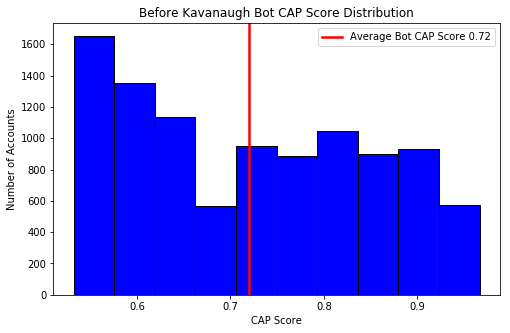%0A)

In \[42\]:

    print(list(full_df))

    ['user_id', 'bot_score', 'tweet_count', 'tweet_time', 'tweet_text', 'user_favourites_count', 'user_statuses_count', 'user_description', 'user_location', 'user_created_at', 'user_verified', 'user_following', 'user_url', 'user_listed_count', 'user_followers_count', 'user_default_profile_image', 'user_utc_offset', 'user_friends_count', 'user_default_profile', 'user_name', 'user_lang', 'user_screen_name', 'user_geo_enabled', 'user_profile_background_color', 'user_profile_image_url', 'user_time_zone', 'user_listed_count.1', 'age_in_days', 'avg_tweets_per_day']

In \[43\]:

    ax = full_df.plot.scatter(x='cap', y='user_favourites_count')

    ---------------------------------------------------------------------------
    KeyError                                  Traceback (most recent call last)
    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
       2524             try:
    -> 2525                 return self._engine.get_loc(key)
       2526             except KeyError:

    pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

    pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

    pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

    pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

    KeyError: 'cap'

    During handling of the above exception, another exception occurred:

    KeyError                                  Traceback (most recent call last)
    <ipython-input-43-9d774ae619b7> in <module>()
    ----> 1 ax = full_df.plot.scatter(x='cap', y='user_favourites_count')

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py in scatter(self, x, y, s, c, **kwds)
       2853         axes : matplotlib.AxesSubplot or np.array of them
       2854         """
    -> 2855         return self(kind='scatter', x=x, y=y, c=c, s=s, **kwds)
       2856 
       2857     def hexbin(self, x, y, C=None, reduce_C_function=None, gridsize=None,

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py in __call__(self, x, y, kind, ax, subplots, sharex, sharey, layout, figsize, use_index, title, grid, legend, style, logx, logy, loglog, xticks, yticks, xlim, ylim, rot, fontsize, colormap, table, yerr, xerr, secondary_y, sort_columns, **kwds)
       2675                           fontsize=fontsize, colormap=colormap, table=table,
       2676                           yerr=yerr, xerr=xerr, secondary_y=secondary_y,
    -> 2677                           sort_columns=sort_columns, **kwds)
       2678     __call__.__doc__ = plot_frame.__doc__
       2679 

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py in plot_frame(data, x, y, kind, ax, subplots, sharex, sharey, layout, figsize, use_index, title, grid, legend, style, logx, logy, loglog, xticks, yticks, xlim, ylim, rot, fontsize, colormap, table, yerr, xerr, secondary_y, sort_columns, **kwds)
       1900                  yerr=yerr, xerr=xerr,
       1901                  secondary_y=secondary_y, sort_columns=sort_columns,
    -> 1902                  **kwds)
       1903 
       1904 

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py in _plot(data, x, y, subplots, ax, kind, **kwds)
       1685         if isinstance(data, DataFrame):
       1686             plot_obj = klass(data, x=x, y=y, subplots=subplots, ax=ax,
    -> 1687                              kind=kind, **kwds)
       1688         else:
       1689             raise ValueError("plot kind %r can only be used for data frames"

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py in __init__(self, data, x, y, s, c, **kwargs)
        835             # the handling of this argument later
        836             s = 20
    --> 837         super(ScatterPlot, self).__init__(data, x, y, s=s, **kwargs)
        838         if is_integer(c) and not self.data.columns.holds_integer():
        839             c = self.data.columns[c]

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py in __init__(self, data, x, y, **kwargs)
        809         if is_integer(y) and not self.data.columns.holds_integer():
        810             y = self.data.columns[y]
    --> 811         if len(self.data[x]._get_numeric_data()) == 0:
        812             raise ValueError(self._kind + ' requires x column to be numeric')
        813         if len(self.data[y]._get_numeric_data()) == 0:

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py in __getitem__(self, key)
       2137             return self._getitem_multilevel(key)
       2138         else:
    -> 2139             return self._getitem_column(key)
       2140 
       2141     def _getitem_column(self, key):

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py in _getitem_column(self, key)
       2144         # get column
       2145         if self.columns.is_unique:
    -> 2146             return self._get_item_cache(key)
       2147 
       2148         # duplicate columns & possible reduce dimensionality

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py in _get_item_cache(self, item)
       1840         res = cache.get(item)
       1841         if res is None:
    -> 1842             values = self._data.get(item)
       1843             res = self._box_item_values(item, values)
       1844             cache[item] = res

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/internals.py in get(self, item, fastpath)
       3841 
       3842             if not isna(item):
    -> 3843                 loc = self.items.get_loc(item)
       3844             else:
       3845                 indexer = np.arange(len(self.items))[isna(self.items)]

    /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
       2525                 return self._engine.get_loc(key)
       2526             except KeyError:
    -> 2527                 return self._engine.get_loc(self._maybe_cast_indexer(key))
       2528 
       2529         indexer = self.get_indexer([key], method=method, tolerance=tolerance)

    pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

    pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

    pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

    pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

    KeyError: 'cap'

In \[12\]:

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.grid(False)
    ax.set_title('Kavanaugh Bot CAP Score Distribution')
    plt.hist(kav_bot_df.cap, bins=10, color='b', edgecolor='k')
    plt.xlabel("CAP Score")
    plt.ylabel("Number of Accounts")
    mean_cap = kav_bot_df.cap.mean()
    rounded = str(round(mean_cap, 2))
    plt.axvline(mean_cap, color='r', linewidth=2.5, label='Average Bot CAP Score '+ str(rounded))

    plt.legend()
    plt.savefig('Before Kavanaugh Bot CAP Score Distribution.png', bbox_inches='tight')

![](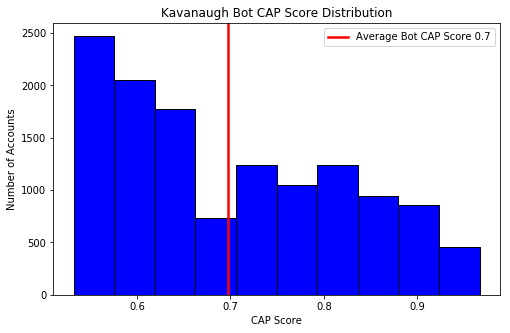%0A)

In \[15\]:

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.grid(False)
    ax.set_title('Account Age Distribution')
    plt.hist(full_df.age_in_days, bins=25, color='b', edgecolor='k')
    plt.xlabel("Age in days")
    plt.ylabel("Number of Accounts")

    mean_age = full_df.age_in_days.mean()
    rounded_age = str(int(mean_age))
    plt.axvline(mean_age, color='r', linewidth=2, linestyle='dashed', label='Overall Average Age '+ str(rounded_age) + ' days')

    mean_bot = full_bot_df.age_in_days.mean()
    rounded_age = str(int(mean_bot))
    plt.axvline(mean_bot, color='y', linewidth=2, linestyle='dashed', label='Average Bot Age '+ str(rounded_age) + ' days')

    mean_bot_before = before_bot_df.age_in_days.mean()
    rounded_age = str(int(mean_bot_before))
    plt.axvline(mean_bot_before, color='m', linewidth=2, linestyle='dashed', label='Average Bot Age Before Kavanaugh '+ str(rounded_age) + ' days')

    mean_bot_after = kav_bot_df.age_in_days.mean()
    rounded_age = str(int(mean_bot_after))
    plt.axvline(mean_bot_after, color='c', linewidth=2, linestyle='dashed', label='Average Bot Age After Kavanaugh '+ str(rounded_age) + ' days')

    plt.legend()
    plt.savefig('Account Age Distribution.png', bbox_inches='tight')

![](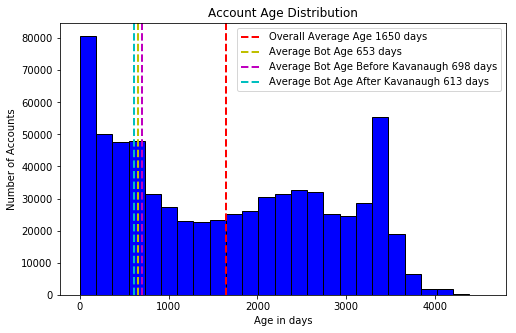%0A)

In \[16\]:

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.grid(False)
    ax.set_title('Before Kavanaugh Account Age Distribution')
    plt.hist(before_bot_df.age_in_days, bins=20, color='b', edgecolor='k')
    plt.xlabel("Account age in days")
    plt.ylabel("Number of Accounts")
    mean_cap = before_bot_df.age_in_days.mean()
    rounded = str(round(mean_cap, 2))
    plt.axvline(mean_cap, color='r', linewidth=2.5, label='Average Account Age in Days '+ str(rounded))

    top50 = get_top_percent(before_bot_df, 'age_in_days', 0.50)
    rounded = str(round(top50, 2))
    plt.axvline(top50, color='orange', linewidth=2.5, linestyle='dashed', label='50th Percentile '+ str(rounded) +' days')

    top10 = get_top_percent(before_bot_df, 'age_in_days', 0.90)
    rounded = str(round(top10, 2))
    plt.axvline(top10, color='g', linewidth=2.5, linestyle='dashed', label='10th Percentile '+ str(rounded) +' days')

    plt.legend()
    plt.savefig('Before Kavanaugh Account Age Distribution.png', bbox_inches='tight')

![](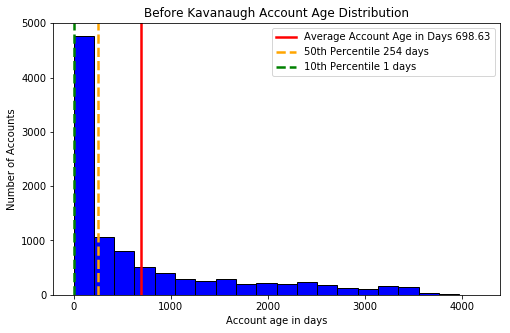%0A)

In \[17\]:

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.grid(False)
    ax.set_title('Kavanaugh Account Age Distribution')

    plt.hist(kav_bot_df.age_in_days, bins=30, color='b', edgecolor='k')
    plt.xlabel("Account Age in Days")
    plt.ylabel("Number of Accounts")
    mean_cap = kav_bot_df.age_in_days.mean()
    rounded = str(round(mean_cap, 2))
    plt.axvline(mean_cap, color='r', linewidth=2.5, label='Average account age in days '+ str(rounded))

    top50 = get_top_percent(kav_bot_df, 'age_in_days', 0.50)
    rounded = str(round(top50, 2))
    plt.axvline(top50, color='orange', linewidth=2.5, linestyle='dashed', label='50th Percentile '+ str(rounded) +' days')

    top10 = get_top_percent(kav_bot_df, 'age_in_days', 0.90)
    rounded = str(round(top10, 2))
    plt.axvline(top10, color='g', linewidth=2.5, linestyle='dashed', label='10th Percentile '+ str(rounded) +' days')

    plt.legend()
    plt.savefig('Kavanaugh Account Age Distribution.png', bbox_inches='tight')

![](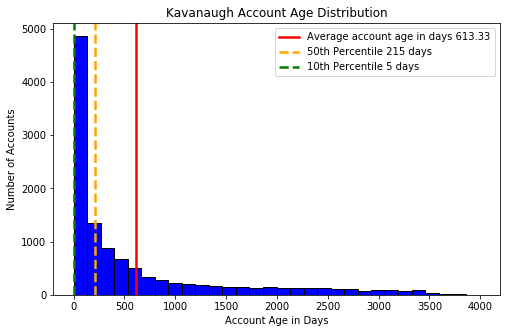%0A)

In \[18\]:

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.grid(False)
    ax.set_title('Average Tweets Per Day')
    bins = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
    plt.hist(full_df.avg_tweets_per_day, bins=bins, color='g', edgecolor='k')
    plt.xlabel("Average Tweets per day")
    plt.ylabel("Number of Accounts")

    mean_age = full_df.avg_tweets_per_day.mean()
    rounded_age = str(int(mean_age))
    plt.axvline(mean_age, color='r', linewidth=2, linestyle='dashed', label='Overall Average TPD '+ str(rounded_age))

    mean_bot = full_bot_df.avg_tweets_per_day.mean()
    rounded_age = str(int(mean_bot))
    plt.axvline(mean_bot, color='y', linewidth=2, linestyle='dashed', label='Average Bot TPD '+ str(rounded_age))

    mean_bot_before = before_bot_df.avg_tweets_per_day.mean()
    rounded_age = str(int(mean_bot_before))
    plt.axvline(mean_bot_before, color='m', linewidth=2, linestyle='dashed', label='Average Bot TPD Before Kavanaugh '+ str(rounded_age))

    mean_bot_after = kav_bot_df.avg_tweets_per_day.mean()
    rounded_age = str(int(mean_bot_after))
    plt.axvline(mean_bot_after, color='c', linewidth=2, linestyle='dashed', label='Average Bot TPD After Kavanaugh '+ str(rounded_age))

    plt.legend()
    plt.savefig('Average Tweets Per Day.png', bbox_inches='tight')

![](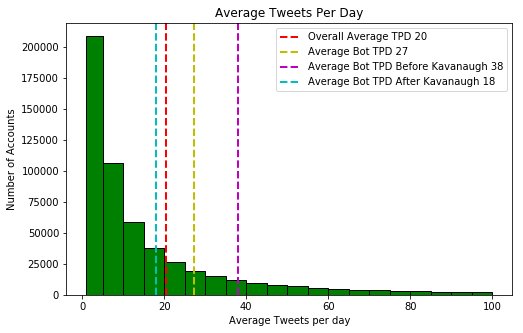%0A)

In \[19\]:

    mean_tweets = full_human_df.user_statuses_count.mean()
    mean_bot_tweets = full_bot_df.user_statuses_count.mean()
    mean_bot_tweets_before = before_bot_df.user_statuses_count.mean()
    mean_bot_tweets_after = kav_bot_df.user_statuses_count.mean()

    print('Average number of tweets for a human ', mean_tweets)
    print('Average number of tweets for a bot ', mean_bot_tweets)
    print('Average number of tweets for a bot before ', mean_bot_tweets_before)
    print('Average number of tweets for a bot after ', mean_bot_tweets_after)

    Average number of tweets for a human  19597.76517024833
    Average number of tweets for a bot  7169.715706415165
    Average number of tweets for a bot before  10656.101391252127
    Average number of tweets for a bot after  4121.454625010939

In \[ \]: